# feature extraction for logistic CVD models
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading predictions

In [3]:
# def get_output_maps_for_ds(output_maps_dir, ids):
#     output_maps_lists = defaultdict(lambda : [])
#     key_order = None
#     for ID in tqdm(ids, position=0, leave=True):
#         output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
#         key_order = natsorted(list(output_maps_data.keys()))
#         for output_type in key_order:
#             output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
#     return output_maps_lists, key_order
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [4]:
# model_name = "SSN_Ens_Mean"
model_name = "ssn_ens"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:41<00:00,  6.08it/s]


In [5]:
# model_name_for_pred = "SSN_Ens_Mean"
model_name_for_pred = "ssn_ens"
output_maps_dir_for_pred = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name_for_pred}/"
output_maps_for_pred, key_order_for_pred = load_output_maps(output_maps_dir_for_pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:26<00:00,  9.41it/s]


In [6]:
key_order

['ent', 'pred', 'seg']

In [7]:
ID = list(output_maps_for_umaps.keys())[2]

In [8]:
img_us = output_maps_for_umaps[ID]
img_ps = output_maps_for_pred[ID]

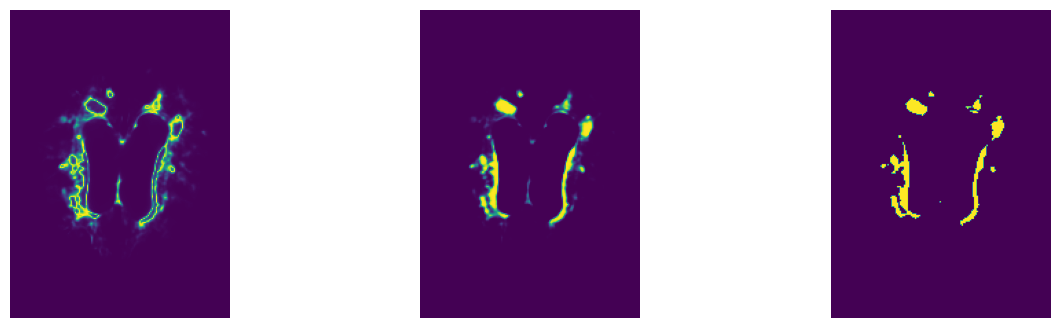

In [9]:
plt.figure(figsize=(15,4))
islice = 31
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_us[i][islice])
    plt.axis('off')

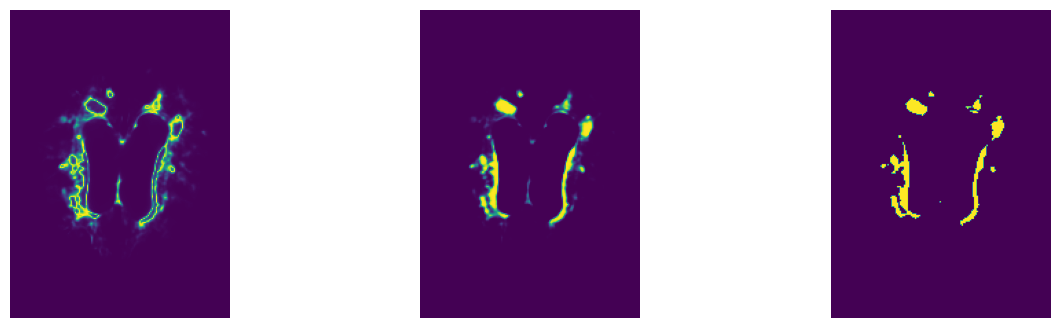

In [11]:
ent, pred, seg = img_ps
plt.figure(figsize=(15,4))
islice = 31
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_ps[i][islice])
    plt.axis('off')

In [69]:
t = 0.1
ent_voxels = ent[ent > t]
pred_voxels = pred[pred > t]
# var_voxels = var[var > t/10]

<Axes: ylabel='Density'>

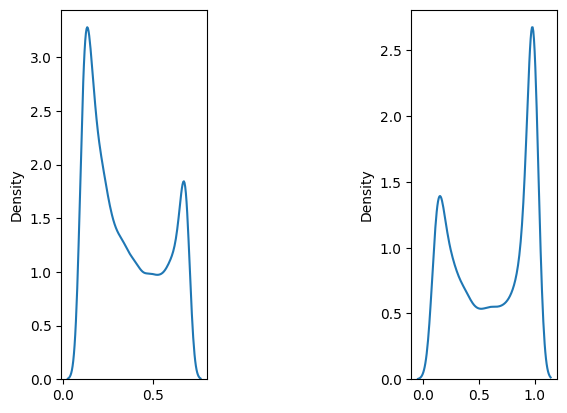

In [13]:
plt.subplot(1,3,1)
sns.kdeplot(ent_voxels)
plt.subplot(1,3,3)
sns.kdeplot(pred_voxels)

In [14]:
def histogram_distribution(values, bins=20, minv=None, maxv=None):
    # so that the output values are meaningful, I need to carefully set the min a max. mnin should be t, and max should be the max across all the data I think.
    if minv == None:
        minv = values.min()
    if maxv == None:
        maxv = values.max()
    counts = torch.zeros(bins)
    bounds = torch.arange(minv,maxv, (maxv-minv)/bins)
    for i, (lower_bound, upper_bound) in enumerate(zip(bounds[:-1], bounds[1:])):
        counts[i] = ((values >= lower_bound) * (values < upper_bound)).sum()

    Z = counts.sum()
    counts = counts / Z
    return counts

In [15]:
def gaussian_summary_statistics(values):
    sum = values.sum().item()
    mean = values.mean().item()
    std = values.std().item()
    skew = scipy.stats.skew(values)
    kurtosis = scipy.stats.kurtosis(values, fisher=False)
    return sum, mean, std, skew, kurtosis

In [16]:
histogram_distribution(ent_voxels, 20)

tensor([0.1305, 0.0964, 0.0776, 0.0617, 0.0558, 0.0469, 0.0409, 0.0393, 0.0364,
        0.0343, 0.0313, 0.0290, 0.0291, 0.0294, 0.0286, 0.0284, 0.0322, 0.0344,
        0.0420, 0.0957])

In [17]:
# counts, counts.sum()

<Axes: ylabel='Count'>

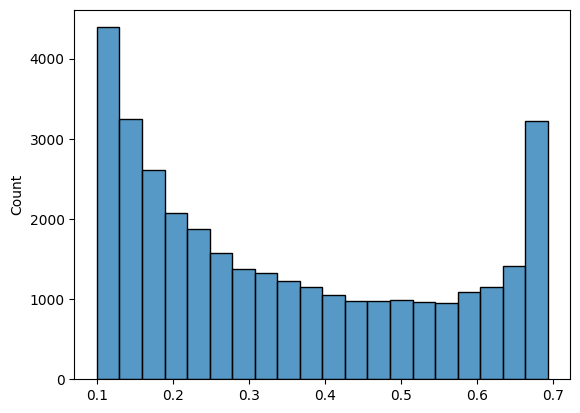

In [18]:
sns.histplot(ent_voxels, bins=20)

### overlap proportions computation
- [x] proportion of segmented area that is uncertain
- [x] proportion of uncertain area that is segmented
- [x] proportion of uncertain area that is within segmentation + edge expansion

In [19]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

### loading the ventricles for ventricle distance analysis

In [20]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tv

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [21]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((224, 160))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [22]:
IDs_outmaps = natsorted(list(output_maps_for_umaps.keys()))
IDs = [("_".join(idx.split("_")[:-2]), idx) for idx in IDs_outmaps if "out_maps" in idx]

In [23]:
IDs_outmaps[0:5], IDs[0:5]

(['CVD001_out_maps',
  'CVD002_out_maps',
  'CVD003_out_maps',
  'CVD004_out_maps',
  'CVD008_out_maps'],
 [('CVD001', 'CVD001_out_maps'),
  ('CVD002', 'CVD002_out_maps'),
  ('CVD003', 'CVD003_out_maps'),
  ('CVD004', 'CVD004_out_maps'),
  ('CVD008', 'CVD008_out_maps')])

In [24]:
output_maps_for_umaps[IDs[0][1]][0].shape

torch.Size([48, 224, 160])

In [25]:
vent_folder = "/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/"
vent_filenames = os.listdir(vent_folder)
ID_ventpath_map = {"_".join(f.split("_")[:-1]): vent_folder + f for f in vent_filenames}
vent_maps = []
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    num_slices = output_maps_for_umaps[ID[1]][0].shape[0]
    vent_path = ID_ventpath_map[ID[0]]
    vent_seg = load_fast_output(vent_path, num_slices)
    vent_maps.append(vent_seg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:21<00:00, 11.49it/s]


In [26]:
vent_maps[0].shape, vent_maps[0].sum(dim=(1,2,)).argmax(0)

(torch.Size([48, 224, 160]), tensor(29))

torch.Size([56, 224, 160])
torch.Size([56, 224, 160])


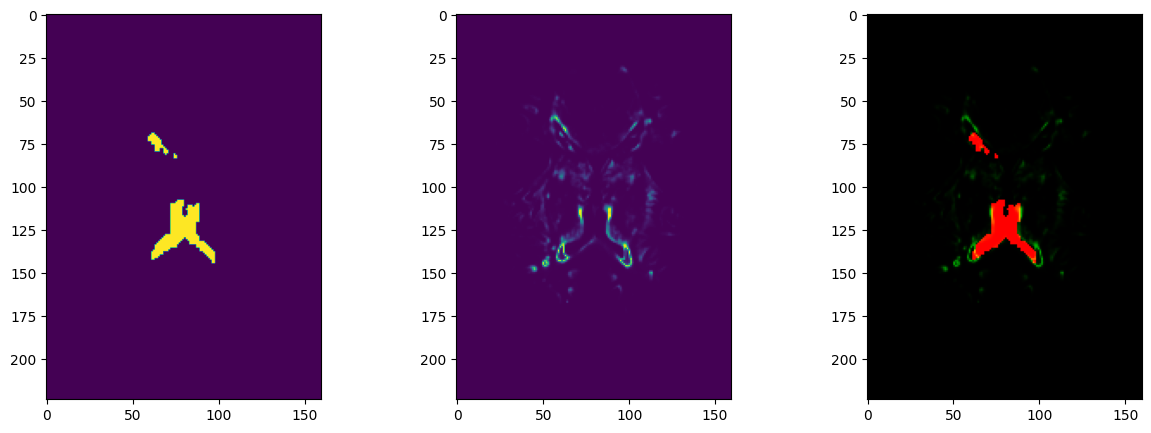

In [27]:
islice = 32
scan_id = 200
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(vent_maps[scan_id][islice])
plt.subplot(1,3,2)
plt.imshow(output_maps_for_umaps[IDs[scan_id][1]][0][islice])
plt.subplot(1,3,3)
img_map = torch.zeros(*vent_maps[scan_id].shape[1:], 3)
print(output_maps_for_umaps[IDs[scan_id][1]][0].shape)
print(vent_maps[scan_id].shape)
img_map[:,:,0] = vent_maps[scan_id][islice]
img_map[:,:,1] = output_maps_for_umaps[IDs[scan_id][1]][0][islice]
plt.imshow(img_map)

### distance from the ventricles

In [28]:
import torch.nn.functional as F
def edge_pixels_3D(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32).unsqueeze(0)
    
    max_pool = F.max_pool3d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool3d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype).squeeze()

def edge_pixels(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32)
    
    max_pool = F.max_pool2d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype)

In [29]:
def downsample_3d(img, avg=True):
    if avg:
        return F.avg_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)
    else:
        return F.max_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)

In [30]:
def min_distances(img, vmap):
    # calculate the minimum distance between each point in a and each point in b
    
    spatial_dims = vmap.squeeze().shape
    grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32).to(img.device)
    
    a = grid[:, img.squeeze() > 0].T.cuda()
    b = grid[:, vmap.squeeze() > 0].T.cuda()
    
    # Calculate pairwise distances between all pairs of points
    distances = torch.cdist(a, b)

    # Find indices of closest points in b for each point in a
    _, indices = torch.min(distances, dim=1)

    # Use indices to index into b and get closest points
    b_closest = b[indices]

    # Calculate distances to closest points 
    distances_closest = torch.norm(a - b_closest, dim=1)
    
    distance_map = torch.zeros(img.shape).to(distances_closest.device)
    distance_map[img > 0] = distances_closest
    
    return distances_closest, distance_map

### connected components analysis

In [31]:
import cc3d

In [32]:
def get_conn_comps(img):
    connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    labels_out_seg = cc3d.connected_components(img.cpu().numpy(), connectivity=connectivity)
    return torch.from_numpy(labels_out_seg.astype(np.int16)).to(img.device)

In [33]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

In [34]:
def skew(t, dim=None):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`

    :return: a scalar
    """

    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(3)).mean(dim=dim)


def kurtosis(t, fisher=True, dim=None):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)

    :return: a scalar
    """
        
    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(4)).mean(dim=dim) - fisher*3

In [35]:
def one_hot_encoded_image(image):
    # for a 3D [H, W, D] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1, 1, 1))

def one_hot_encoded_vector(vector):
    return (vector == vector.unique().view(-1,1))

In [36]:
def conn_comp_basic_stats(umap, conn_comp_map, seg_map, dist_map):
    # number of connected components
    # size of connected components
    # connected component size distribution information
    cc_ids = conn_comp_map.unique()
    cc_locs = conn_comp_map != 0
    conn_comp_map = conn_comp_map[cc_locs]
    umap = umap[cc_locs]
    seg_map = seg_map[cc_locs]
    dist_map = dist_map[cc_locs]
    
    assert dist_map.shape == seg_map.shape == umap.shape == conn_comp_map.shape
    num_ccs = len(cc_ids) - 1
    num_ccs_no_overlap = 0
    cc_sizes = []
    cc_means = []
    cc_stds = []
    cc_skews = []
    cc_kurts = []
    cc_vent_dists = []
    for cc_id in cc_ids:
        if cc_id == 0:
            continue
        cc = conn_comp_map == cc_id
        cc_size = cc.sum().item()
        cc_values = umap[cc]
        _, mean, std, skew, kurtosis = gaussian_summary_statistics(cc_values.cpu())
    
        cc_sizes.append(cc_size)
        cc_means.append(mean)
        cc_stds.append(std)
        cc_skews.append(skew)
        cc_kurts.append(kurtosis)
        
        if seg_map[cc].sum() == 0:
            num_ccs_no_overlap += 1
            
        cc_vent_dists.append(dist_map[cc].mean().item())
    _, vd_mean, vd_std, vd_skew, vd_kurt = gaussian_summary_statistics(torch.Tensor(cc_vent_dists))
    _, size_mean, size_std, size_skew, size_kurt = gaussian_summary_statistics(torch.Tensor(cc_sizes))
    
    return {"num":num_ccs, "sizes":cc_sizes, "means":cc_means, "stds":cc_stds, "skews":cc_skews, "kurts":cc_kurts, "vent_dists":cc_vent_dists, "unsegmented_ccs":num_ccs_no_overlap, "size_mean":size_mean, "size_std":size_std, "size_skew":size_skew, "size_kurt":size_kurt, "vd_mean":vd_mean, "vd_std":vd_std, "vd_skew":vd_skew, "vd_kurt":vd_kurt}



In [37]:
# idx = 0
# example_umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
# example_smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
# example_vmap = vent_maps[idx].cuda()

# vmap_ds = downsample_3d(example_vmap)
# umap_ds = downsample_3d(example_umap)
# ut_ds = umap_ds > 0.1
# ut = example_umap > 0.1
# conn_comps = get_conn_comps(ut)

# distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
# distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), example_umap.shape, mode='trilinear').squeeze()

In [38]:
# cc_data = conn_comp_basic_stats(example_umap, conn_comps, example_smap, distance_map) # from this we could get the mean mean, mean std, mean skew and mean kurtosis for each threshold I guess. # that would be somewhat interesting

In [39]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [40]:
# cc_data["log_sizes"] = torch.Tensor(cc_data['sizes']).log()
# sns.jointplot(cc_data, y="vent_dists", x="log_sizes", bins=5, kind='hist')

In [41]:
def joint_hist_values(data, x, y, minx, maxx, miny, maxy, bins=5):
    values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
    values = values.expand((bins, bins, *values.shape))
    counts = torch.zeros(bins, bins)
    bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1)).to(values.device)
    bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1)).to(values.device)
    upper_xlims = bounds_x[1:].view(1, 5, 1)
    upper_ylims = bounds_y[1:].view(5, 1, 1)
    lower_xlims = bounds_x[:-1].view(1, 5, 1)
    lower_ylims = bounds_y[:-1].view(5, 1, 1)
    counts = (values[:,:,:,0] < upper_xlims) * (values[:,:,:,0] > lower_xlims) * (values[:,:,:,1] < upper_ylims) * (values[:,:,:,1] > lower_ylims)
    counts = counts.sum(dim=-1)

    Z = counts.sum()
    counts = counts / Z
    return counts


# def joint_hist_values2(data, x, y, minx, maxx, miny, maxy, bins=5):
#     values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
#     #values = values.expand((bins, bins, *values.shape))
#     counts = torch.zeros(bins, bins)
#     bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1))
#     bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1))
#     upper_xlims = bounds_x[1:]
#     upper_ylims = bounds_y[1:]
#     lower_xlims = bounds_x[:-1]
#     lower_ylims = bounds_y[:-1]
#     for i, (x1, x2) in enumerate(zip(lower_xlims, upper_xlims)):
#         for j, (y1,y2) in enumerate(zip(lower_ylims, upper_ylims)):
#             counts[i][j] = ((values[:,0] < x2) * (values[:,0] > x1) * (values[:,1] < y2) * (values[:,1] > y1)).sum()
#     # counts = counts.sum(dim=-1)

#     Z = counts.sum()
#     counts = counts / Z
#     return counts

In [42]:
# joint_counts = joint_hist_values2(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5)

In [43]:
# joint_counts.shape

In [44]:
# plt.imshow(joint_counts); plt.colorbar()

In [45]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [46]:
# summary statistics of log conn comp size:
# cc_summary_stats = gaussian_summary_statistics(torch.Tensor(cc_data['sizes']).log())

In [47]:
# sum, mean , std, skew, kurtosis of log size of connected components.
# cc_summary_stats

In [48]:
# histogram_distribution(torch.Tensor(cc_data['sizes']).log(), 10)

In [49]:
# plt.hist(torch.Tensor(cc_data['sizes']).log(), bins=10);

In [50]:
# sns.jointplot(data=cc_data, x="sizes", y="kurts")
# plt.xscale('log')

In [51]:
# lets get basic distribution of connected component numbers and size. Then we can get some interesting plots later, so collect as much interesting information as possible...
# I can compare this to number and size of connected components in the predicted map (at say tau > 0.5?)
# I should get distance of each connected component from the ventricles and size. yes that is a good plot
# also distance from the binarized segmentation... (but I need to be careful and do this for pred as well as umap).

### Uncertainty values that I intended to extract from the umap

For SSN Ens for the ent and var maps, and SSN Ens Mean for the pred and seg maps. Nice.
I should capture all of these metrics across a variety of metrics, and I can tune the thresholds in cross validation. simples.
It may be the case that ent + var together give us some more information. That would be interesting.

`output_maps_for_umaps` is the SSN_Ens output
`output_maps_for_mean` is the SSN_Ens_mean output

- [x] sum
- [x] mean
- [x] std
- [x] skew
- [x] kurtosis
- [x] kde bins?
- [x] ventricle size
- [x] intensity distribution (need to ensure that the min and max of the bins are the same across all individuals) 
- [x] number of connected components
- [x] size of connected components distribution, need to ensure that the min and max of the bins are the same across all individuals.
- [x] number / distribution of connected components that have no overlap with the segmented mask... (again I need the umap and the pred map to do this) (and I should also compare to the seg map as well perhaps)
- [x] uncertainty sum, mean, skew, kurtosis of each connected component. That may be interesting to plot.
- [-] distance to the WMH binarized segmentation for each connected component (try to separate out those connected components that are highlighting other stuff).
- [-] proportion of the segmented edge deemed uncertain (if we expand the edge of the segmentation then calculate the proportion, we can get the sum of the uncertainty that
- [x] proportion of segmented area deemed uncertain (this requires access to SSN Ens and SSN Ens Mean at the same time
- [x] proportion of uncertain area that is within the segmentation + edge area
- [x] distribution of size of connected components (sum, mean, std, skew)
- [x] distance from the ventricles (could do this in x, y and z distributions, or just overall...) I could measure distance x intensity
- [x] stats for distance from the ventricles (mean, std, skew, kurtosis, etc)
- [x] mean distance from the ventricles of each connected component joint with size in a 5x5 and 10x10 bin option I think. again ensure that the 
- [ ] predicted seg volume.

### turning all of the above into a big loop

need to compute values for:
- [x] ent map
- [x] var map
- [x] pred map
- [x] loop over [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] as threshold for ent map
- [x] loop over [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] for pred map
- [x] loop over ? for ent map

In [65]:
data = {}
failed_ids = []
for idx in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[idx][0]
    print(ID)
    try:
        vmap = vent_maps[idx].cuda()
        smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
        smap_expanded = get_edge_expanded_seg(smap)
        seg_volume = smap.sum().item()
        vent_volume = vmap.sum().item()
        vmap_ds = downsample_3d(vmap)

        ind_data = {}

        for input_type in ["ent", "pred"]:
            if input_type == "ent":
                umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
                maxv = 0.7
            # elif input_type == "var":
            #     umap = output_maps_for_umaps[IDs[idx][1]][3].cuda()
            #     ts = [0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
            #     maxv = 0.2
            elif input_type == "pred":
                umap = output_maps_for_pred[IDs[idx][1]][1].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                maxv = 1.0
            else:
                raise ValueError  

            umap_ds = downsample_3d(umap)

            collected_data_t = {}

            for t in ts:
                ut = umap > t
                umap_values = umap[ut]

                #### summary statistics
                sum, mean, std, skew, kurtosis = gaussian_summary_statistics(umap_values.cpu())
                values_hist = histogram_distribution(umap_values, bins=20, minv=t, maxv=maxv)

                #### overlap statistics
                intersection = (ut * smap).sum()
                expanded_intersection = (ut * smap_expanded).sum()

                prop_umap_segmented = (intersection / ut.sum()).item()
                prop_umap_within_expanded_seg = (expanded_intersection / ut.sum()).item()
                prop_seg_uncertain = (intersection / smap.sum()).item()

                ### ventricle distance statistics
                ut_ds = umap_ds > t
                distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
                distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), umap.shape, mode='trilinear').squeeze()
                _, dist_mean, dist_std, dist_skew, dist_kurt = gaussian_summary_statistics(distances_closest.cpu())
                umap_ds_values = umap_ds[ut_ds]
                dist_value_joint = joint_hist_values({"x":distances_closest, "y":umap_ds_values}, x="x", y="y", minx=0, maxx=30, miny=t, maxy=maxv, bins=5).cpu()

                ### connected component analysis statistics
                conn_comps = get_conn_comps(ut)
                cc_data = conn_comp_basic_stats(umap, conn_comps, smap, distance_map)
                cc_data["log_sizes"] = torch.Tensor(cc_data["sizes"]).log()
                cc_size_dist_joint = joint_hist_values(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5).cpu()

                # recorded values
                all_data = {}
                for key, value in cc_data.items():
                    all_data["cc_" + key] = value
                all_data["sum"] = sum
                all_data["mean"] = mean
                all_data["std"] = std
                all_data["skew"] = skew
                all_data["kurtosis"] = kurtosis
                all_data["prop_umap_segmented"] = prop_umap_segmented
                all_data["prop_umap_within_expanded_seg"] = prop_umap_within_expanded_seg
                all_data["prop_seg_uncertain"] = prop_seg_uncertain
                all_data["dist_mean"] = dist_mean
                all_data["dist_std"] = dist_std
                all_data["dist_skew"] = dist_skew
                all_data["dist_kurt"] = dist_kurt
                all_data["dist_value_joint"] = dist_value_joint
                all_data["cc_dist_value_joint"] = cc_size_dist_joint
                all_data["seg_volume"] = seg_volume
                all_data["vent_volume"] = vent_volume
                all_data["values_hist"] = values_hist

                print(all_data["cc_num"], all_data["cc_unsegmented_ccs"])
                collected_data_t[str(t)] = all_data


                # break

            ind_data[input_type] = collected_data_t
            # break

        data[ID] = ind_data
        # break
    except:
        failed_ids.append((idx, ID))
    # break
        

  0%|                                                                                                                                                                 | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_2757902/1284179010.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = scipy.stats.skew(values)
/tmp/ipykernel_2757902/1284179010.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(values, fisher=False)


CVD001
84 83
104 103
91 90
74 73
73 72
44 43
36 35
19 16
12 7


  0%|▌                                                                                                                                                        | 1/250 [00:01<05:27,  1.31s/it]

16 9
14 0
11 0
CVD002
280 275
185 179
135 128
98 80
97 66
142 77
56 46
44 30
40 24
31 8


  1%|█▏                                                                                                                                                       | 2/250 [00:03<07:33,  1.83s/it]

28 0
30 0
CVD003
142 133
116 101
103 75
255 105
388 132
623 179
62 44
46 24
37 10
36 6


  1%|█▊                                                                                                                                                       | 3/250 [00:06<10:24,  2.53s/it]

34 0
31 0
CVD004
247 241
150 141
116 105
81 62
93 66
115 74
67 49
87 60
80 47


  2%|██▍                                                                                                                                                      | 4/250 [00:09<09:58,  2.43s/it]

72 29
54 0
44 0
CVD008
117 100
96 73
120 76
221 113
303 128
467 199
72 41
69 27
69 20
62 10
63 0


  2%|███                                                                                                                                                      | 5/250 [00:12<11:05,  2.72s/it]

66 0
CVD009
437 435
297 289
223 201
233 176
261 172
333 191
128 110
109 83
73 44
47 13
46 0


  2%|███▋                                                                                                                                                     | 6/250 [00:16<13:22,  3.29s/it]

43 0
CVD011
281 266
173 156
141 120
126 95
137 92
166 108
110 85
88 57
80 43
64 17


  3%|████▎                                                                                                                                                    | 7/250 [00:19<12:49,  3.17s/it]

51 0
48 0
CVD012
272 269
157 151
78 69
80 59
79 53
122 70
56 44
44 29
43 25
33 11


  3%|████▉                                                                                                                                                    | 8/250 [00:21<11:17,  2.80s/it]

31 0
30 0
CVD013
139 135
100 93
77 64
84 52
120 59
144 68
52 36
40 22
35 16
34 9


  4%|█████▌                                                                                                                                                   | 9/250 [00:23<09:58,  2.48s/it]

34 0
29 0
CVD014
180 178
139 133
100 89
95 78
86 65
92 63
72 58
60 39
66 34
75 28


  4%|██████                                                                                                                                                  | 10/250 [00:25<09:34,  2.39s/it]

60 0
40 0
CVD016
210 178
173 145
176 128
261 157
389 182
698 267
112 76
99 51
80 27
94 26
74 0


  4%|██████▋                                                                                                                                                 | 11/250 [00:30<12:26,  3.12s/it]

78 0
CVD017
204 200
92 85
68 59
68 56
73 53
83 55
56 45
50 35
47 25
39 14
29 0


  5%|███████▎                                                                                                                                                | 12/250 [00:32<10:49,  2.73s/it]

26 0
CVD018
126 126
67 67
3 3
4 4


  5%|███████▉                                                                                                                                                | 13/250 [00:32<08:11,  2.07s/it]

3 3
0 0
0 0
0 0
0 0
0 0
0 0
0 0
CVD019
201 189
101 87
85 68
73 50
81 54
100 64
60 43
48 27
41 18
35 8


  6%|████████▌                                                                                                                                               | 14/250 [00:34<07:54,  2.01s/it]

31 0
25 0
CVD020
231 224
209 186
183 144
186 126
220 129
306 154
122 74
116 58
104 39
90 20
81 0


  6%|█████████                                                                                                                                               | 15/250 [00:38<09:52,  2.52s/it]

79 0
CVD021
239 217
187 156
170 132
177 113
241 140
287 140
130 85
109 55
96 36
79 12
80 0


  6%|█████████▋                                                                                                                                              | 16/250 [00:41<11:00,  2.82s/it]

75 0
CVD023
322 312
217 202
158 132
177 118
211 109
324 133
89 66
67 39
52 20
43 6
46 0


  7%|██████████▎                                                                                                                                             | 17/250 [00:45<11:45,  3.03s/it]

41 0
CVD024
198 187
110 99
85 66
94 63
118 67
152 72
54 40
50 36
39 21
31 10


  7%|██████████▉                                                                                                                                             | 18/250 [00:47<10:34,  2.74s/it]

25 0
24 0
CVD025
108 94
90 77
119 91
222 106
420 146
724 233
58 43
47 29
38 17
39 10


  8%|███████████▌                                                                                                                                            | 19/250 [00:51<11:45,  3.05s/it]

38 0
29 0
CVD028
167 151
131 117
145 102
361 142
593 170
973 270
72 52
61 33
65 26
60 15
59 0


  8%|████████████▏                                                                                                                                           | 20/250 [00:56<14:21,  3.75s/it]

65 0
CVD030
157 147
107 95
91 76
87 67
81 57
78 53
68 52
45 24
37 13
38 4


  8%|████████████▊                                                                                                                                           | 21/250 [00:58<12:08,  3.18s/it]

38 0
33 0
CVD031
246 233
173 156
147 124
177 127
229 141
342 190
115 88
109 68
98 44
98 23


  9%|█████████████▍                                                                                                                                          | 22/250 [01:02<12:46,  3.36s/it]

98 0
84 0
CVD032
149 139
120 106
90 67
137 85
178 102
213 103
82 59
71 41
67 30
57 14
47 0


  9%|█████████████▉                                                                                                                                          | 23/250 [01:04<11:49,  3.13s/it]

42 0
CVD033
248 234
173 152
148 110
212 112
301 126
448 171
104 65
88 41
75 25
69 14


 10%|██████████████▌                                                                                                                                         | 24/250 [01:08<12:37,  3.35s/it]

62 0
64 0
CVD034
232 218
153 131
137 98
184 91
241 101
326 129
99 61
83 40
75 29
71 15


 10%|███████████████▏                                                                                                                                        | 25/250 [01:12<12:37,  3.37s/it]

69 0
63 0
CVD035
176 171
106 101
79 71
63 49
65 45
66 34
44 36
25 17


 10%|███████████████▊                                                                                                                                        | 26/250 [01:13<10:27,  2.80s/it]

22 12
14 3
15 0
15 0
CVD036
177 168
131 112
127 85
306 128
584 197
947 293
74 42
72 32
63 20
60 13
55 0


 11%|████████████████▍                                                                                                                                       | 27/250 [01:18<12:54,  3.48s/it]

58 0
CVD037
125 125
24 24
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


 11%|█████████████████                                                                                                                                       | 28/250 [01:19<09:30,  2.57s/it]

0 0
CVD038
200 188
135 117
118 93
128 78
159 79
224 94
88 59
88 54
73 33
60 16
55 0


 12%|█████████████████▋                                                                                                                                      | 29/250 [01:21<09:41,  2.63s/it]

48 0
CVD039
197 175
145 115
160 109
241 124
328 152
456 194
95 51
92 40
79 16
85 12
92 0


 12%|██████████████████▏                                                                                                                                     | 30/250 [01:25<11:04,  3.02s/it]

89 0
CVD040
210 201
163 152
134 104
236 131
337 159
457 182
86 67
64 40
59 27
68 28
49 0


 12%|██████████████████▊                                                                                                                                     | 31/250 [01:29<11:45,  3.22s/it]

60 0
CVD041
220 217
148 139
125 105
187 96
294 131
511 178
71 53
43 20
42 16
32 3


 13%|███████████████████▍                                                                                                                                    | 32/250 [01:32<11:52,  3.27s/it]

36 0
33 0
CVD042
257 248
100 91
60 51
64 46
68 45
103 57
41 31
37 26
26 15


 13%|████████████████████                                                                                                                                    | 33/250 [01:34<10:08,  2.80s/it]

18 4
18 0
15 0
CVD043
179 175
139 133
101 85
118 67
144 76
193 88
52 40
44 29
35 16
27 4


 14%|████████████████████▋                                                                                                                                   | 34/250 [01:36<09:26,  2.62s/it]

28 0
26 0
CVD045
157 132
146 105
162 105
287 122
516 186
848 276
109 60
90 32
101 30
104 18
102 0


 14%|█████████████████████▎                                                                                                                                  | 35/250 [01:41<12:06,  3.38s/it]

102 0
CVD047
447 433
284 261
227 190
237 162
267 166
316 168
173 137
129 85
105 53
105 36
91 0


 14%|█████████████████████▉                                                                                                                                  | 36/250 [01:46<13:22,  3.75s/it]

87 0
CVD048
300 276
233 194
194 140
247 145
303 150
435 178
143 91
129 58
108 31
104 18
109 0


 15%|██████████████████████▍                                                                                                                                 | 37/250 [01:50<13:58,  3.94s/it]

106 0
CVD049
249 244
151 137
96 82
94 65
94 49
114 49
63 47
49 31
44 23
40 13


 15%|███████████████████████                                                                                                                                 | 38/250 [01:53<11:52,  3.36s/it]

33 0
28 0
CVD050
180 168
120 100
106 72
121 71
145 79
211 97
91 48
82 33
85 26
81 18
71 0


 16%|███████████████████████▋                                                                                                                                | 39/250 [01:55<10:55,  3.11s/it]

68 0
CVD052
475 415
438 366
392 304
398 270
439 268
455 243
242 157
202 110
164 64
147 37
121 0


 16%|████████████████████████▎                                                                                                                               | 40/250 [02:01<14:03,  4.01s/it]

114 0
CVD055
252 243
135 124
89 77
77 58
74 55
74 52
57 43
47 32
42 23
34 12


 16%|████████████████████████▉                                                                                                                               | 41/250 [02:03<11:49,  3.39s/it]

24 0
24 0
CVD056
212 206
128 119
84 72
70 54
65 46
75 47
44 29
41 25


 17%|█████████████████████████▌                                                                                                                              | 42/250 [02:05<09:54,  2.86s/it]

36 16
34 7
32 0
23 0
CVD060
150 122
126 85
133 66
230 98
336 129
509 188
112 46
121 31
123 22
122 15
117 0


 17%|██████████████████████████▏                                                                                                                             | 43/250 [02:09<10:57,  3.18s/it]

116 0
CVD061
235 228
176 159
125 95
177 107
216 117
295 136
98 69
92 52
96 45
97 31


 18%|██████████████████████████▊                                                                                                                             | 44/250 [02:12<11:01,  3.21s/it]

91 0
84 0
CVD063
481 467
276 254
220 188
196 150
203 143
205 125
140 112
96 59
79 39
63 17


 18%|███████████████████████████▎                                                                                                                            | 45/250 [02:16<11:24,  3.34s/it]

51 0
51 0
CVD064
128 124
106 98
97 78
96 59
130 73
228 89
47 32
55 28
52 21
49 10
52 0


 18%|███████████████████████████▉                                                                                                                            | 46/250 [02:18<10:05,  2.97s/it]

54 0
CVD065
291 275
168 142
145 109
182 106
267 113
447 161
94 64
92 55
75 33
63 15
55 0


 19%|████████████████████████████▌                                                                                                                           | 47/250 [02:21<10:31,  3.11s/it]

55 0
CVD068
213 204
126 110
104 77
111 67
130 64
177 80
69 44
59 27
58 20


 19%|█████████████████████████████▏                                                                                                                          | 48/250 [02:23<09:35,  2.85s/it]

52 9
44 0
35 0
CVD070
187 180
118 108
122 100
140 85
187 92
251 92
77 55
67 40
56 23


 20%|█████████████████████████████▊                                                                                                                          | 49/250 [02:26<09:11,  2.75s/it]

49 13
50 0
45 0
CVD073
302 274
206 174
152 116
152 101
202 122
255 128
130 88
113 59
95 40
91 25
79 0


 20%|██████████████████████████████▍                                                                                                                         | 50/250 [02:29<09:46,  2.93s/it]

78 0
CVD074
173 157
122 105
97 78
107 82
126 83
153 88
78 58
71 44
55 21


 20%|███████████████████████████████                                                                                                                         | 51/250 [02:31<08:57,  2.70s/it]

55 15
45 0
41 0
CVD075
364 359
203 195
123 115
97 87
92 75
86 60
70 61
42 32
25 13
18 5


 21%|███████████████████████████████▌                                                                                                                        | 52/250 [02:34<08:29,  2.58s/it]

14 0
12 0
CVD076
153 133
160 123
158 109
227 121
301 147
378 162
125 75
97 39
88 27
91 22


 21%|████████████████████████████████▏                                                                                                                       | 53/250 [02:37<09:25,  2.87s/it]

79 0
69 0
CVD077
262 258
193 184
145 132
172 130
225 146
306 158
80 69
56 45
41 22
43 20


 22%|████████████████████████████████▊                                                                                                                       | 54/250 [02:40<09:23,  2.87s/it]

29 0
38 0
CVD078
189 162
134 99
134 90
144 84
169 91
197 103
103 63
84 39
74 26
72 16
63 0


 22%|█████████████████████████████████▍                                                                                                                      | 55/250 [02:43<09:03,  2.79s/it]

55 0
CVD079
312 306
156 150
114 105
85 63
89 54
105 59
50 42
45 36
40 30


 22%|██████████████████████████████████                                                                                                                      | 56/250 [02:45<08:13,  2.54s/it]

26 10
23 0
21 0
CVD080
187 181
114 105
96 81
103 66
122 65
140 65
66 49
57 38
47 23
48 13


 23%|██████████████████████████████████▋                                                                                                                     | 57/250 [02:47<07:37,  2.37s/it]

39 0
23 0
CVD081
211 206
108 103
86 79
92 76
98 66
105 53
60 48
39 22
42 23


 23%|███████████████████████████████████▎                                                                                                                    | 58/250 [02:49<07:09,  2.24s/it]

40 14
38 0
35 0
CVD082
190 185
91 85
82 75
95 83
84 71
96 73
88 78
48 36
36 23


 24%|███████████████████████████████████▊                                                                                                                    | 59/250 [02:50<06:36,  2.07s/it]

26 9
21 0
21 0
CVD083
320 310
201 178
186 152
248 157
308 165
467 193
127 94
127 82
104 47
96 22
98 0


 24%|████████████████████████████████████▍                                                                                                                   | 60/250 [02:54<08:35,  2.71s/it]

80 0
CVD084
403 390
253 236
164 140
149 106
162 99
197 98
104 81
65 38
53 22


 24%|█████████████████████████████████████                                                                                                                   | 61/250 [02:57<08:47,  2.79s/it]

48 13
39 0
30 0
CVD085
272 265
157 146
124 111
98 76
100 68
123 68
57 44
56 37
41 20
38 12


 25%|█████████████████████████████████████▋                                                                                                                  | 62/250 [03:00<08:05,  2.58s/it]

36 0
30 0
CVD086
200 186
125 108
104 80
119 67
147 68
189 76
70 44
69 35
67 27
64 16
53 0


 25%|██████████████████████████████████████▎                                                                                                                 | 63/250 [03:02<07:49,  2.51s/it]

50 0
CVD088
266 258
153 142
107 87
129 80
173 89
247 115
52 38
43 25
41 21
37 10


 26%|██████████████████████████████████████▉                                                                                                                 | 64/250 [03:04<07:40,  2.48s/it]

35 0
25 0
CVD089
286 270
192 171
143 115
164 105
194 104
263 127
83 56
69 35
65 23
66 17
55 0


 26%|███████████████████████████████████████▌                                                                                                                | 65/250 [03:07<08:05,  2.63s/it]

60 0
CVD090
155 147
83 67
83 64
107 69
144 80
191 101
75 57
67 47
46 24
37 12


 26%|████████████████████████████████████████▏                                                                                                               | 66/250 [03:09<07:27,  2.43s/it]

29 0
29 0
CVD091
214 211
106 100
101 93
74 66
60 52
62 49
43 35
39 29
35 25


 27%|████████████████████████████████████████▋                                                                                                               | 67/250 [03:11<06:35,  2.16s/it]

22 10
16 0
12 0
CVD092
234 228
109 103
87 75
84 50
99 54
118 56
34 27
23 15
22 12


 27%|█████████████████████████████████████████▎                                                                                                              | 68/250 [03:12<06:09,  2.03s/it]

17 4
21 0
20 0
CVD096
304 295
163 150
111 92
104 83
96 70
97 64
89 71
53 32
47 21
43 14
36 0


 28%|█████████████████████████████████████████▉                                                                                                              | 69/250 [03:15<06:15,  2.07s/it]

30 0
CVD097
273 258
140 124
128 107
104 71
108 67
122 64
62 42
56 32
54 27


 28%|██████████████████████████████████████████▌                                                                                                             | 70/250 [03:17<06:19,  2.11s/it]

39 11
31 0
31 0
CVD098
330 317
206 190
133 111
112 74
141 73
190 88
74 51
40 16
45 20
45 12


 28%|███████████████████████████████████████████▏                                                                                                            | 71/250 [03:20<06:52,  2.31s/it]

42 0
42 0
CVD100
224 215
147 137
106 92
87 67
96 66
115 66
58 43
52 37
37 18
33 12


 29%|███████████████████████████████████████████▊                                                                                                            | 72/250 [03:22<06:30,  2.19s/it]

30 0
26 0
CVD102
217 209
161 148
129 104
191 116
246 119
427 174
74 54
75 49
59 29


 29%|████████████████████████████████████████████▍                                                                                                           | 73/250 [03:25<07:16,  2.47s/it]

48 11
47 0
45 0
CVD103
260 249
114 87
77 53
125 65
176 82
289 112
60 40
53 28
55 26
48 12
52 0


 30%|████████████████████████████████████████████▉                                                                                                           | 74/250 [03:27<07:19,  2.50s/it]

49 0
CVD104
261 253
136 127
109 96
84 64
91 57
84 45
64 51
31 16
35 17
32 9


 30%|█████████████████████████████████████████████▌                                                                                                          | 75/250 [03:29<06:44,  2.31s/it]

23 0
21 0
CVD105
164 159
97 89
73 61
64 49
69 47
74 45
36 25
32 17
33 17


 30%|██████████████████████████████████████████████▏                                                                                                         | 76/250 [03:31<05:56,  2.05s/it]

32 12
25 0
23 0
CVD106
149 129
143 118
121 87
162 92
228 117
390 156
97 57
94 41
90 32
93 19
90 0


 31%|██████████████████████████████████████████████▊                                                                                                         | 77/250 [03:34<06:52,  2.38s/it]

82 0
CVD107
111 104
91 73
97 60
235 102
426 149
699 210
50 33
52 28
43 14
45 10


 31%|███████████████████████████████████████████████▍                                                                                                        | 78/250 [03:37<07:45,  2.71s/it]

41 0
42 0
CVD108
226 208
145 124
122 91
143 90
165 94
184 97
95 67
81 50
66 30
62 18
55 0


 32%|████████████████████████████████████████████████                                                                                                        | 79/250 [03:40<07:34,  2.66s/it]

48 0
CVD111
344 326
216 192
191 149
241 158
286 174
396 216
125 88
114 59
108 42
109 27


 32%|████████████████████████████████████████████████▋                                                                                                       | 80/250 [03:44<08:51,  3.13s/it]

115 0
102 0
CVD112
275 234
225 176
204 148
207 133
234 135
281 139
150 89
132 63
113 36
113 21
101 0


 32%|█████████████████████████████████████████████████▏                                                                                                      | 81/250 [03:48<09:23,  3.33s/it]

96 0
CVD113
262 258
194 189
137 127
104 84
110 83
119 74
70 55
51 31
53 28


 33%|█████████████████████████████████████████████████▊                                                                                                      | 82/250 [03:50<08:26,  3.01s/it]

48 17
39 0
33 0
CVD114
229 200
144 103
158 91
211 96
272 112
349 132
81 39
78 30
81 30
70 14
62 0


 33%|██████████████████████████████████████████████████▍                                                                                                     | 83/250 [03:53<08:32,  3.07s/it]

59 0
CVD115
175 163
151 135
152 111
289 142
448 172
680 234
80 55
76 47
66 30
51 9
51 0


 34%|███████████████████████████████████████████████████                                                                                                     | 84/250 [03:57<09:16,  3.35s/it]

48 0
CVD116
321 308
164 149
108 92
89 68
108 71
140 80
74 56
69 44
53 27
40 10


 34%|███████████████████████████████████████████████████▋                                                                                                    | 85/250 [04:00<08:22,  3.05s/it]

33 0
29 0
CVD117
293 288
161 152
140 128
137 101
152 105
178 100
90 80
44 31
50 33
38 11


 34%|████████████████████████████████████████████████████▎                                                                                                   | 86/250 [04:02<07:53,  2.89s/it]

47 0
39 0
CVD118
299 289
211 192
133 113
191 108
327 144
531 191
81 67
58 37
52 20
60 17
57 0


 35%|████████████████████████████████████████████████████▉                                                                                                   | 87/250 [04:06<08:32,  3.15s/it]

47 0
CVD121
263 236
164 131
154 114
160 103
170 101
188 111
116 77
110 58
93 33
99 21


 35%|█████████████████████████████████████████████████████▌                                                                                                  | 88/250 [04:09<08:30,  3.15s/it]

94 0
83 0
CVD124
375 372
280 263
209 180
200 148
225 137
284 141
137 108
92 54
83 36
79 20


 36%|██████████████████████████████████████████████████████                                                                                                  | 89/250 [04:13<08:54,  3.32s/it]

71 0
57 0
CVD126
192 173
148 119
142 97
175 91
258 112
373 137
84 43
76 30
73 19
63 5
72 0


 36%|██████████████████████████████████████████████████████▋                                                                                                 | 90/250 [04:16<08:42,  3.27s/it]

62 0
CVD127
257 250
156 147
113 101
93 75
92 69
112 72
66 52
45 28
41 16
45 11


 36%|███████████████████████████████████████████████████████▎                                                                                                | 91/250 [04:18<07:44,  2.92s/it]

44 0
43 0
CVD128
186 182
143 135
106 96
87 73
93 66
119 71
56 45
40 26
32 16
25 6
22 0


 37%|███████████████████████████████████████████████████████▉                                                                                                | 92/250 [04:20<06:49,  2.59s/it]

25 0
CVD129
191 181
127 118
119 101
152 106
194 110
285 120
90 72
78 56
69 41
63 20
54 0


 37%|████████████████████████████████████████████████████████▌                                                                                               | 93/250 [04:23<06:53,  2.64s/it]

47 0
CVD130
344 336
182 173
132 119
112 94
93 71
100 67
72 57
38 22
33 13
24 3
22 0


 38%|█████████████████████████████████████████████████████████▏                                                                                              | 94/250 [04:25<06:35,  2.53s/it]

21 0
CVD132
247 241
136 128
89 81
69 61
64 54
67 45
56 47
35 24


 38%|█████████████████████████████████████████████████████████▊                                                                                              | 95/250 [04:27<06:00,  2.33s/it]

25 12
17 4
16 0
16 0
CVD133
242 233
131 119
75 63
62 48
55 32
69 32
35 23
29 15


 38%|██████████████████████████████████████████████████████████▎                                                                                             | 96/250 [04:28<05:22,  2.10s/it]

27 13
20 5
19 0
19 0
CVD134
254 239
121 104
104 77
127 85
197 110
257 125
78 55
80 50
65 33


 39%|██████████████████████████████████████████████████████████▉                                                                                             | 97/250 [04:31<05:55,  2.33s/it]

53 16
42 0
40 0
CVD137
279 272
164 153
115 95
119 80
130 75
178 84
64 46
59 37
45 22
36 7


 39%|███████████████████████████████████████████████████████████▌                                                                                            | 98/250 [04:34<06:03,  2.39s/it]

38 0
34 0
CVD138
266 260
141 133
107 94
90 66
113 66
160 73
51 38
47 27
38 15
39 9


 40%|████████████████████████████████████████████████████████████▏                                                                                           | 99/250 [04:36<05:59,  2.38s/it]

47 0
48 0
CVD140
184 170
109 86
136 82
200 98
274 113
384 136
73 44
64 31
54 15
58 10
60 0


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 100/250 [04:39<06:37,  2.65s/it]

62 0
CVD141
265 257
182 168
156 140
124 102
111 84
134 85
82 61
90 59
86 50


 40%|█████████████████████████████████████████████████████████████                                                                                          | 101/250 [04:42<06:45,  2.72s/it]

61 19
48 0
33 0
CVD143
243 228
161 144
130 110
112 87
119 83
165 100
95 67
66 36
64 30
62 19
58 0


 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 102/250 [04:45<06:41,  2.72s/it]

63 0
CVD145
126 118
70 58
73 56
86 56
99 60
101 56
57 37
61 33
58 28
55 18


 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 103/250 [04:47<05:59,  2.44s/it]

47 0
40 0
CVD146
461 454
250 237
213 189
173 123
199 104
262 106
90 72
69 47
57 29


 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 104/250 [04:50<06:43,  2.77s/it]

46 15
37 0
33 0
CVD148
309 297
175 159
116 97
112 79
127 76
141 80
64 45
41 17
36 10
35 7


 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 105/250 [04:52<06:19,  2.62s/it]

31 0
29 0
CVD150
298 279
153 127
132 93
187 100
235 102
310 118
72 46
52 23
43 13
38 6


 42%|████████████████████████████████████████████████████████████████                                                                                       | 106/250 [04:55<06:32,  2.73s/it]

32 0
31 0
CVD151
295 287
238 219
214 180
249 151
320 164
392 159
122 101
91 60
80 38
71 20


 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 107/250 [04:59<07:26,  3.12s/it]

56 0
54 0
CVD152
258 256
180 174
157 147
141 115
155 104
227 118
69 58
55 38
46 24
40 14


 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 108/250 [05:02<07:02,  2.98s/it]

34 0
33 0
CVD153
264 246
167 143
140 98
201 118
271 129
412 184
87 57
68 31
71 24
57 8
53 0


 44%|█████████████████████████████████████████████████████████████████▊                                                                                     | 109/250 [05:06<07:19,  3.12s/it]

55 0
CVD155
129 122
73 65
55 43
63 35
93 40
116 46
35 24
29 15


 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 110/250 [05:07<06:06,  2.62s/it]

30 13
30 9
22 0
21 0
CVD156
174 159
133 114
113 84
152 104
176 109
228 113
94 62
88 46
85 35
76 16
77 0


 44%|███████████████████████████████████████████████████████████████████                                                                                    | 111/250 [05:10<06:14,  2.69s/it]

75 0
CVD157
166 161
123 98
89 71
199 99
321 115
543 155
40 31
38 26


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 112/250 [05:13<06:31,  2.84s/it]

28 14
23 5
24 0
25 0
CVD158
294 287
194 180
163 131
211 124
272 130
372 158
110 82
103 60
95 42
91 25
83 0


 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 113/250 [05:17<07:11,  3.15s/it]

67 0
CVD161
188 174
121 104
113 92
137 84
190 95
239 92
71 51
51 28
43 17


 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 114/250 [05:19<06:41,  2.95s/it]

46 15
36 0
30 0
CVD165
463 456
334 321
218 199
199 167
189 138
233 135
119 93
86 54
74 39
62 22


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 115/250 [05:23<07:15,  3.23s/it]

52 0
46 0
CVD166
600 585
351 326
249 212
239 177
274 171
385 193
166 126
136 80
128 65
94 23
83 0


 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 116/250 [05:29<08:35,  3.85s/it]

79 0
CVD167
185 166
130 111
119 92
194 118
298 143
507 171
103 80
76 46
56 19
53 13


 47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 117/250 [05:32<08:22,  3.78s/it]

48 0
40 0
CVD169
243 234
158 148
111 100
95 79
91 72
104 78
62 49
63 44
54 27
48 15
54 0


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 118/250 [05:34<07:19,  3.33s/it]

63 0
CVD170
129 121
101 89
108 81
189 92
293 101
450 130
71 46
60 29
54 18


 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 119/250 [05:38<07:05,  3.25s/it]

48 7
45 0
44 0
CVD171
244 240
161 153
128 118
117 99
125 95
143 90
86 77
54 40
49 31


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 120/250 [05:40<06:29,  3.00s/it]

42 13
43 0
29 0
CVD172
443 407
247 200
196 144
241 163
248 154
266 153
148 97
111 56
96 34
86 18
76 0


 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 121/250 [05:44<07:10,  3.34s/it]

71 0
CVD173
340 326
248 217
204 158
373 181
608 239
916 325
105 81
79 47
54 21
44 10
40 0


 49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 122/250 [05:50<08:32,  4.01s/it]

29 0
CVD174
134 127
110 94
114 85
199 98
295 121
474 161
75 55
61 36
68 34
60 15
65 0


 49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 123/250 [05:53<08:00,  3.78s/it]

52 0
CVD175
154 150
69 65
55 48
56 43
78 50
104 51
37 29
40 29
47 24


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 124/250 [05:55<06:36,  3.15s/it]

40 13
38 0
28 0
CVD176
253 239
167 149
142 108
175 113
247 127
310 141
88 67
70 44
61 31


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 125/250 [05:58<06:33,  3.15s/it]

41 8
40 0
45 0
CVD177
344 339
222 208
167 130
213 116
251 117
330 141
67 51
43 25
42 15
38 6


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 126/250 [06:01<06:39,  3.22s/it]

43 0
42 0
CVD178
228 217
124 107
99 68
129 65
171 73
228 85
45 28
38 19
29 8
33 9
27 0


 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 127/250 [06:03<06:03,  2.95s/it]

25 0
CVD179
188 172
140 127
111 95
162 104
264 127
492 196
87 69
66 42
52 22
54 13
56 0


 51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 128/250 [06:07<06:16,  3.09s/it]

56 0
CVD181
165 143
111 89
122 88
223 104
386 141
616 204
61 34
81 44
68 28
55 10
57 0


 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 129/250 [06:11<06:37,  3.28s/it]

55 0
CVD183
150 145
70 61
50 37
72 39
90 42
118 58
39 23
43 25
45 19
42 11
36 0


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 130/250 [06:12<05:39,  2.83s/it]

28 0
CVD184
216 212
132 125
101 94
88 78
101 79
126 76
58 49
58 39
50 26
56 21
49 0


 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 131/250 [06:15<05:13,  2.63s/it]

45 0
CVD186
219 216
167 159
112 100
108 85
123 86
175 113
74 59
76 50
73 36
66 17
74 0


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 132/250 [06:17<05:18,  2.69s/it]

68 0
CVD188
289 279
162 138
147 94
309 138
480 180
705 249
99 69
79 44
59 22
46 6
46 0


 53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 133/250 [06:22<06:30,  3.34s/it]

49 0
CVD191
380 366
252 229
225 185
239 162
308 176
447 214
150 116
119 80
91 46
90 30
78 0


 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 134/250 [06:27<07:13,  3.74s/it]

62 0
CVD192
279 276
178 173
119 113
106 90
109 88
128 91
88 77
65 51
53 29


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 135/250 [06:29<06:24,  3.35s/it]

44 14
42 0
32 0
CVD193
298 295
200 196
181 173
142 133
127 115
120 101
99 91
69 55
62 42


 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 136/250 [06:32<06:04,  3.20s/it]

45 22
29 0
30 0
CVD194
143 137
97 89
66 56
45 32
38 21
56 32
38 27
23 9
25 10
28 5
32 0


 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 137/250 [06:34<05:04,  2.69s/it]

36 0
CVD195
140 132
72 67
82 51
255 78
459 129
768 201
26 18
26 16


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 138/250 [06:37<05:33,  2.98s/it]

24 11
21 5
26 0
20 0
CVD200
195 186
128 112
134 94
177 110
238 112
359 130
77 53
68 39
71 37
61 19
48 0


 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 139/250 [06:40<05:36,  3.03s/it]

47 0
CVD201
173 163
117 106
77 63
91 62
97 59
142 73
64 46
55 36
39 20
28 7


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 140/250 [06:43<05:01,  2.74s/it]

25 0
31 0
CVD202
139 133
163 77
107 71
242 96
450 135
855 262
38 26
39 22
34 17
35 12
36 0


 56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 141/250 [06:47<05:50,  3.22s/it]

31 0
CVD203
211 200
117 98
123 91
183 84
283 108
423 142
72 40
66 23
65 12
68 7
78 0


 57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 142/250 [06:50<05:58,  3.32s/it]

70 0
CVD204
138 131
94 83
112 61
286 117
406 149
545 203
39 23
33 13
34 9
39 7
47 0


 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 143/250 [06:54<05:58,  3.35s/it]

49 0
CVD205
118 109
105 93
96 73
190 94
327 116
572 195
65 33
72 33
77 31
73 13
75 0


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 144/250 [06:57<06:00,  3.40s/it]

94 0
CVD206
197 185
129 113
96 79
102 64
101 49
129 52
45 31
38 21


 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 145/250 [06:59<05:15,  3.01s/it]

34 16
32 11
23 0
20 0
CVD207
199 195
126 121
120 106
120 96
146 99
175 98
83 70
69 48
58 30


 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 146/250 [07:02<04:54,  2.83s/it]

50 16
42 0
41 0
CVD208
307 306
230 225
192 180
175 145
182 130
231 122
91 78
63 42
60 29
50 8
58 0


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 147/250 [07:05<05:05,  2.97s/it]

60 0
CVD213
210 205
93 85
83 67
93 57
102 48
135 51
50 38
38 26


 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 148/250 [07:07<04:28,  2.63s/it]

30 15
23 7
24 0
22 0
CVD214
192 181
107 93
99 69
224 97
365 122
564 163
46 26
36 11
31 4
34 1
39 0


 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 149/250 [07:10<04:49,  2.87s/it]

42 0
CVD216
318 311
196 188
116 106
114 93
125 92
138 85
97 81
74 50
55 27


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 150/250 [07:13<04:44,  2.85s/it]

42 10
41 0
38 0
CVD218
270 263
183 171
142 123
142 99
171 104
257 125
97 77
72 44
73 32
59 13
55 0


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 151/250 [07:16<04:47,  2.90s/it]

39 0
CVD219
209 201
144 128
99 80
121 80
131 73
171 72
74 48
65 37
65 31
48 12
48 0


 61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 152/250 [07:19<04:29,  2.75s/it]

46 0
CVD220
127 122
83 72
88 64
144 76
171 75
204 78
54 39
38 20
32 9
31 5


 61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 153/250 [07:21<04:07,  2.55s/it]

29 0
22 0
CVD221
349 339
243 226
197 175
152 116
163 112
201 125
95 75
69 42
54 23
46 3
56 0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 154/250 [07:24<04:26,  2.77s/it]

45 0
CVD225
321 303
223 197
146 117
162 110
205 110
300 128
103 69
77 41
66 28
60 18
49 0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 155/250 [07:27<04:37,  2.93s/it]

48 0
CVD226
308 277
186 147
143 99
144 84
155 79
166 78
94 53
69 26
55 12
54 7
57 0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 156/250 [07:30<04:31,  2.89s/it]

53 0
CVD229
357 341
242 225
168 146
141 117
148 115
144 102
143 118
85 51
75 37
63 22


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 157/250 [07:33<04:36,  2.97s/it]

50 0
52 0
CVD230
321 315
191 180
160 147
126 104
123 92
140 93
85 71
64 39
70 33
73 22
60 0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 158/250 [07:36<04:30,  2.94s/it]

51 0
CVD231
213 189
162 133
121 89
116 69
122 65
157 84
79 45
79 39
70 27
57 12
56 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 159/250 [07:39<04:17,  2.83s/it]

54 0
CVD233
170 163
114 101
106 87
144 79
251 109
438 168
46 32
58 39
42 20
42 11


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 160/250 [07:42<04:15,  2.83s/it]

45 0
40 0
CVD234
233 229
164 158
135 126
115 88
152 93
216 103
74 62
54 34
47 27
42 18


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 161/250 [07:44<04:03,  2.73s/it]

27 0
25 0
CVD235
258 253
124 116
98 90
82 70
69 54
74 45
55 45
28 17


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 162/250 [07:46<03:34,  2.44s/it]

20 9
20 6
21 0
23 0
CVD236
230 216
124 106
107 78
129 71
156 83
200 93
73 43
59 27
51 18


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 163/250 [07:48<03:34,  2.47s/it]

49 12
43 0
38 0
CVD237
259 245
189 169
200 146
344 160
541 221
797 254
104 67
93 44
89 31
85 18
78 0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 164/250 [07:54<04:43,  3.29s/it]

72 0
CVD238
292 284
181 170
123 97
132 74
154 70
187 79
65 46
62 38
60 26
57 15
58 0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 165/250 [07:56<04:24,  3.12s/it]

49 0
CVD239
215 205
166 147
178 129
238 119
295 135
462 193
97 70
80 48
74 35
64 20
58 0


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 166/250 [08:00<04:36,  3.29s/it]

53 0
CVD240
282 265
187 165
134 112
100 71
102 61
107 48
71 48
54 28
49 20
40 9
37 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 167/250 [08:02<04:09,  3.01s/it]

35 0
CVD241
63 56
65 48
70 47
193 73
396 108
773 199
32 17
24 6
24 4
30 5
31 0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 168/250 [08:06<04:13,  3.09s/it]

23 0
CVD242
184 166
142 115
140 90
269 125
393 163
611 240
95 59
86 39
85 24
80 12
77 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 169/250 [08:10<04:36,  3.42s/it]

75 0
CVD245
312 300
166 152
119 103
105 81
107 74
122 80
77 56
70 47
53 24
37 8


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 170/250 [08:12<04:07,  3.10s/it]

35 0
23 0
CVD246
280 259
178 150
120 84
144 84
167 84
186 80
85 48
81 40
83 32
77 22
66 0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 171/250 [08:15<04:03,  3.09s/it]

62 0
CVD247
252 234
177 154
150 117
190 125
233 135
281 149
120 83
101 59
82 35
64 14


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 172/250 [08:19<04:10,  3.22s/it]

60 0
57 0
CVD248
180 171
100 90
80 61
117 65
144 65
198 72
57 41
40 21
38 15
43 14


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 173/250 [08:21<03:44,  2.92s/it]

31 0
35 0
CVD249
149 143
84 73
85 63
163 77
279 107
442 163
43 24
49 20
49 13
53 12
48 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 174/250 [08:24<03:42,  2.93s/it]

49 0
CVD250
220 202
168 136
137 92
173 86
231 100
318 117
83 45
87 46
71 21
68 10
66 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 175/250 [08:27<03:47,  3.03s/it]

67 0
CVD251
253 234
154 128
97 65
105 49
143 58
183 65
59 29
52 19
47 8
47 5
48 0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 176/250 [08:30<03:30,  2.85s/it]

47 0
CVD252
111 105
92 74
120 76
240 102
365 140
536 185
66 47
63 36
67 28
70 19
57 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 177/250 [08:33<03:42,  3.05s/it]

45 0
CVD253
244 220
132 99
113 78
110 62
116 63
127 63
72 37
55 17
54 12
52 6
53 0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 178/250 [08:36<03:27,  2.88s/it]

45 0
CVD254
214 206
187 174
164 147
147 122
146 110
176 119
123 99
94 55
78 32
73 20


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 179/250 [08:39<03:26,  2.91s/it]

66 0
67 0
CVD255
340 326
172 163
188 129
221 126
333 147
533 189
79 60
57 29
48 18
53 10
55 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 180/250 [08:43<03:47,  3.24s/it]

50 0
CVD256
188 184
96 89
95 82
63 51
61 45
85 46
56 45
34 19
23 8


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 181/250 [08:44<03:09,  2.75s/it]

24 6
23 0
16 0
CVD257
378 373
289 283
172 163
121 106
113 89
109 70
83 73
49 36
37 16
34 9


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 182/250 [08:47<03:06,  2.75s/it]

34 0
30 0
CVD258
180 166
125 108
133 105
152 99
216 107
348 136
89 61
77 35
84 30
78 19
80 0


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 183/250 [08:50<03:13,  2.89s/it]

88 0
CVD259
230 217
137 117
102 80
90 57
113 60
152 70
61 36
59 31
52 17
53 12
44 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 184/250 [08:52<02:59,  2.72s/it]

41 0
CVD260
142 139
83 69
82 60
111 63
159 81
214 81
62 38
59 30
67 32
61 17
58 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 185/250 [08:55<02:48,  2.60s/it]

58 0
CVD261
289 287
224 218
161 152
133 112
140 105
170 110
88 76
65 50
40 24
36 16


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 186/250 [08:58<02:48,  2.64s/it]

30 0
28 0
CVD262
237 229
144 133
75 61
80 62
69 44
78 46
62 46
45 26
35 13
35 8


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 187/250 [08:59<02:31,  2.40s/it]

37 0
29 0
CVD263
204 196
102 93
78 68
71 52
73 42
79 45
44 30
41 25
44 25


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 188/250 [09:01<02:15,  2.19s/it]

34 11
27 0
23 0
CVD264
272 264
172 158
137 120
103 75
119 73
152 81
61 45
48 29
49 25
40 11


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 189/250 [09:04<02:20,  2.31s/it]

37 0
30 0
CVD265
237 219
145 119
125 94
130 80
148 75
207 91
97 59
89 45
72 26
66 11
66 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 190/250 [09:06<02:27,  2.46s/it]

52 0
CVD266
266 264
184 179
140 131
155 117
204 122
278 127
82 74
69 56
50 33


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 191/250 [09:10<02:35,  2.63s/it]

48 23
37 0
29 0
CVD267
210 197
138 122
86 68
84 58
87 57
95 50
52 34
42 18
45 16
43 10


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 192/250 [09:12<02:22,  2.46s/it]

37 0
35 0
CVD268
247 228
205 163
179 129
293 130
457 169
722 245
99 60
86 38
82 28
73 17
68 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 193/250 [09:16<03:00,  3.16s/it]

70 0
CVD269
162 151
114 99
118 83
189 104
272 127
431 175
78 51
57 23
65 21
55 8
53 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 194/250 [09:20<02:56,  3.16s/it]

47 0
CVD270
324 312
211 192
178 145
197 133
250 136
323 148
110 82
82 53
65 30
54 15


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 195/250 [09:23<02:59,  3.26s/it]

46 0
43 0
CVD271
377 363
263 246
192 170
157 128
139 104
156 110
104 83
66 44
49 21
44 14
35 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 196/250 [09:26<02:52,  3.20s/it]

30 0
CVD272
172 168
105 99
78 68
66 52
70 49
82 53
53 41
48 32
53 26


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 197/250 [09:28<02:26,  2.76s/it]

43 10
41 0
32 0
CVD273
219 215
143 134
104 94
87 74
84 62
96 62
60 50
29 18
18 7
16 2


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 198/250 [09:30<02:09,  2.49s/it]

20 0
20 0
CVD274
234 224
146 134
91 75
99 75
108 75
107 68
77 57
60 35
53 24


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 199/250 [09:32<02:03,  2.42s/it]

45 11
39 0
36 0
CVD275
252 244
189 176
165 140
153 98
225 113
343 140
82 62
79 45
68 27
64 17
59 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 200/250 [09:35<02:14,  2.69s/it]

58 0
CVD276
189 174
142 124
95 69
108 61
120 50
153 56
51 29
41 17
33 8
27 2


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 201/250 [09:37<02:02,  2.49s/it]

27 0
24 0
CVD277
214 206
149 138
130 108
155 101
211 113
329 149
69 55
60 37
59 31
38 7
49 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 202/250 [09:40<02:06,  2.63s/it]

54 0
CVD278
191 182
144 134
131 112
109 83
112 77
152 84
68 50
64 41
49 24
41 10


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 203/250 [09:43<02:00,  2.56s/it]

40 0
41 0
CVD279
250 245
173 166
128 117
94 77
99 66
113 59
59 46
36 16
36 14
38 11


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 204/250 [09:45<01:53,  2.46s/it]

28 0
25 0
CVD280
210 196
117 102
78 56
91 52
120 65
167 71
57 39
53 31
59 28
61 18
52 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 205/250 [09:47<01:47,  2.39s/it]

50 0
CVD281
199 182
143 119
107 82
110 74
137 83
167 74
92 63
71 38
66 27
52 8
56 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 206/250 [09:50<01:46,  2.42s/it]

51 0
CVD282
196 186
92 76
73 51
76 48
90 46
111 47
58 36
47 24
36 10
36 4


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 207/250 [09:51<01:36,  2.24s/it]

37 0
24 0
CVD283
243 232
220 204
211 178
323 176
545 240
919 338
111 94
105 80
72 41
53 15
45 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 208/250 [09:57<02:13,  3.17s/it]

44 0
CVD284
219 212
174 161
162 141
156 120
179 117
214 108
98 73
89 54
77 36
71 22
61 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 209/250 [10:00<02:08,  3.12s/it]

49 0
CVD285
122 114
96 83
80 64
112 75
139 85
137 68
66 48
45 27
41 21
32 9


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 210/250 [10:02<01:50,  2.75s/it]

29 0
27 0
CVD286
186 168
130 108
123 93
152 96
165 95
206 104
93 57
101 55
87 36
85 25
72 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 211/250 [10:04<01:47,  2.76s/it]

63 0
CVD287
307 272
235 184
177 113
221 115
292 135
378 169
124 61
111 40
107 29
94 10


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 212/250 [10:09<02:00,  3.18s/it]

92 0
93 0
CVD288
164 154
103 90
79 64
92 65
109 70
118 65
61 42
64 40
64 36


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 213/250 [10:11<01:44,  2.81s/it]

49 19
35 0
32 0
CVD289
231 228
179 169
180 166
173 146
189 148
212 145
144 124
82 60
62 35
45 15
36 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 214/250 [10:14<01:43,  2.87s/it]

27 0
CVD290
353 347
203 194
116 105
97 82
93 69
93 56
60 45
50 34
38 20


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 215/250 [10:16<01:35,  2.71s/it]

30 8
31 0
25 0
CVD291
281 274
195 181
162 142
145 99
170 95
257 115
95 73
72 48
52 25


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 216/250 [10:19<01:35,  2.80s/it]

48 19
36 0
26 0
CVD292
68 67
28 27
29 28
25 23
21 19
15 13
18 16
5 3


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 217/250 [10:20<01:11,  2.17s/it]

7 5
5 3
6 0
3 0
CVD293
269 264
202 190
189 160
213 142
280 154
386 176
131 104
104 70
102 61
74 29
59 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 218/250 [10:24<01:26,  2.72s/it]

47 0
CVD294
209 205
137 132
105 94
107 80
134 84
159 90
67 54
42 26
33 12
32 3


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 219/250 [10:26<01:19,  2.56s/it]

35 0
24 0
CVD295
174 161
130 100
117 89
189 113
277 136
434 191
83 58
63 30
59 25
55 16
46 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 220/250 [10:29<01:22,  2.76s/it]

58 0
CVD296
209 182
165 129
134 90
169 83
225 83
303 97
86 42
68 20
69 18
75 16
70 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 221/250 [10:32<01:23,  2.88s/it]

68 0
CVD297
235 198
171 127
164 102
237 104
312 125
433 155
113 54
111 44
97 23
99 19
91 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 222/250 [10:36<01:30,  3.23s/it]

90 0
CVD298
162 157
118 110
92 84
71 62
64 52
58 39
56 48
38 28
26 15
22 8
16 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 223/250 [10:38<01:13,  2.73s/it]

9 0
CVD299
171 163
112 96
134 95
239 107
360 128
559 186
59 39
47 24
43 17
39 11


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 224/250 [10:41<01:16,  2.96s/it]

34 0
34 0
CVD300
268 261
195 186
140 131
124 113
112 96
131 101
94 82
55 39
43 25
32 12


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 225/250 [10:44<01:09,  2.80s/it]

29 0
23 0
CVD301
285 273
190 175
146 127
111 70
131 72
160 73
66 43
71 43
70 37


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 226/250 [10:46<01:06,  2.75s/it]

55 20
40 0
36 0
CVD302
218 208
172 159
72 59
53 38
66 46
69 42
49 34
48 26
36 12
36 8


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 227/250 [10:48<00:56,  2.47s/it]

33 0
29 0
CVD303
189 180
131 120
90 78
69 54
59 41
75 51
55 41
54 32
55 28


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 228/250 [10:50<00:50,  2.28s/it]

47 14
42 0
39 0
CVD304
184 181
137 131
96 90
77 65
64 48
65 44
54 43
33 21


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 229/250 [10:52<00:44,  2.11s/it]

31 18
27 9
21 0
22 0
CVD305
205 184
149 121
137 94
181 95
246 105
359 146
89 52
74 33
66 22
66 16
57 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 230/250 [10:55<00:49,  2.45s/it]

59 0
CVD306
243 238
144 139
118 110
94 75
104 66
130 67
42 36
28 20


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 231/250 [10:57<00:44,  2.33s/it]

28 18
23 7
28 0
23 0
CVD307
304 295
174 161
104 90
74 52
66 41
67 39
48 32
36 17
38 16


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 232/250 [10:59<00:40,  2.25s/it]

33 8
30 0
21 0
CVD308
181 175
107 98
77 66
90 66
89 59
95 54
59 47
41 24
40 21
29 9


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 233/250 [11:01<00:35,  2.09s/it]

24 0
15 0
CVD309
161 145
129 108
133 93
173 80
245 92
362 124
71 42
61 29
72 31
63 15
56 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 234/250 [11:04<00:39,  2.45s/it]

63 0
CVD310
357 319
263 240
217 185
287 188
449 244
706 332
180 142
169 118
136 74
134 53
119 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 235/250 [11:10<00:52,  3.47s/it]

120 0
CVD311
221 215
136 130
104 98
101 89
110 89
142 94
66 57
37 26
31 17
27 8


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 236/250 [11:12<00:43,  3.08s/it]

26 0
28 0
CVD312
242 221
133 107
147 96
212 102
302 116
511 175
77 39
76 30
65 17
67 10
65 0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 237/250 [11:16<00:42,  3.27s/it]

59 0
CVD313
180 166
87 73
83 62
84 44
111 56
131 60
46 27
35 15
34 12
31 4
38 0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 238/250 [11:18<00:34,  2.84s/it]

35 0
CVD314
145 137
118 106
119 96
159 82
250 112
383 141
69 44
68 33
62 23
50 8
59 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 239/250 [11:21<00:31,  2.89s/it]

52 0
CVD315
271 265
168 162
104 96
81 66
75 49
87 45
56 42
54 39
42 23
42 13


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 240/250 [11:23<00:26,  2.66s/it]

46 0
38 0
CVD316
255 244
176 163
117 99
123 78
159 85
179 79
61 42
50 28
42 15
36 8


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 241/250 [11:25<00:23,  2.61s/it]

33 0
36 0
CVD317
238 236
113 105
80 71
65 53
64 49
67 48
63 50
42 27
30 14
28 6


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 242/250 [11:27<00:18,  2.34s/it]

25 0
18 0
CVD318
188 179
138 125
124 101
140 99
194 117
261 111
102 73
94 55
83 41
66 18


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 243/250 [11:30<00:17,  2.51s/it]

58 0
48 0
CVD319
206 193
163 133
133 105
153 90
227 114
356 148
92 58
80 43
71 21
63 6
69 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 244/250 [11:33<00:16,  2.74s/it]

66 0
CVD320
217 206
133 117
108 81
117 68
157 78
204 82
77 53
63 27
62 21
65 14
61 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 245/250 [11:36<00:13,  2.68s/it]

54 0
CVD321
274 250
206 172
167 125
167 105
195 100
249 116
110 70
95 48
88 36
68 13


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 246/250 [11:39<00:11,  2.85s/it]

64 0
58 0
CVD322
213 209
142 133
86 74
65 49
75 54
90 63
61 45
49 31
42 22
34 8


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 247/250 [11:41<00:07,  2.56s/it]

31 0
27 0
CVD323
218 202
164 140
128 100
130 83
143 72
199 81
85 52
83 36
82 31
68 12
67 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 248/250 [11:44<00:05,  2.63s/it]

54 0
CVD324
286 266
177 150
158 117
224 109
323 136
497 193
85 51
68 26
69 18
74 13
74 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 249/250 [11:48<00:03,  3.06s/it]

77 0
CVD325
163 146
96 77
89 62
81 48
98 47
136 60
48 30
44 23
36 12
36 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [11:49<00:00,  2.84s/it]

40 0
37 0


In [66]:
len(data)

250

In [67]:
import pandas as pd

In [68]:
pd_dfs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))
pd_other_data_dfs = defaultdict(lambda : [])

for ID_key in tqdm(natsorted(data.keys()), position=0, leave=True):
    ind_data = data[ID_key]
    for input_key in natsorted(ind_data.keys()):
        map_type_data = ind_data[input_key]
        for t_key in natsorted(map_type_data.keys()):
            row_data = map_type_data[t_key]
            
            #row = []
            pd_dfs[input_key][t_key]['ID'].append(ID_key)
            for key in ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist']:
                if 'joint' not in key and 'hist' not in key:
                    #row.append((key, row_data[key]))
                    pd_dfs[input_key][t_key][key].append(row_data[key])
                else:
                    table_vals = row_data[key].view(-1).tolist()
                    for i in range(len(table_vals)):
                        #row.append((f"{key}_{i}", table_vals[i]))
                        pd_dfs[input_key][t_key][f"{key}_{i}"].append(table_vals[i])
                        
            for key in ['cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_log_sizes']:
                pd_other_data_dfs[key].extend(row_data[key])
            pd_other_data_dfs["id"].extend([f"{ID_key}_{input_key}_{t_key}" for _ in range(len(row_data['cc_sizes']))])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 182.53it/s]


In [71]:
# save the summary statistics
ind_data = data[list(data.keys())[0]]
for input_key in tqdm(natsorted(ind_data.keys()), position=0, leave=True):
    map_type_data = ind_data[input_key]
    for t_key in natsorted(map_type_data.keys()):
        df = pd.DataFrame(pd_dfs[input_key][t_key])
        df.to_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/{model_name}_{input_key}_{t_key}.csv")
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.79it/s]


In [72]:
# save the per individual connected component statistic
# np_df = {}
# for key in pd_other_data_dfs.keys():
#     np_df[key] = np.array(pd_other_data_dfs[key])
# np.save(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/{model_name}_connected_component_data.npy", np_df)

### loading the preprepared clin_scores data

In [74]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from trustworthai.utils.data_preprep.splits import cross_validate_split

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
# from torchsampler import ImbalancedDatasetSampler
print("banana")

strawberry
banana


In [75]:
clin_retriever = ClinScoreDataRetriever(use_updated_scores=True)

In [76]:
class CustomClinFieldsDataset(torch.utils.data.Dataset):
    # this is just a wrapper on the clinical dataset where I am hard coding a few things, such as one hot encodings, and all the other stuff that
    # I might want to compute like tab fazekas and total fazekas etc
    def __init__(self, base_dataset):
        super().__init__()
        self.base_dataset = base_dataset
        
    def __getitem__(self, idx):
        x, y, clin_data = self.base_dataset[idx]
        r = clin_data.copy()
        
        # smoking
        r['smoking_0'] = (r['smoking'] == 0).astype(np.float32)
        r['smoking_1'] = (r['smoking'] == 1).astype(np.float32)
        r['smoking_2'] = (r['smoking'] == 2).astype(np.float32)
        
        # total fazekas and scale fazekas
        dwmh = r['DWMH']
        pvwmh = r['PVWMH']
        total_fazekas = np.nan
        if (not np.isnan(dwmh)) and (not np.isnan(pvwmh)):
            total_fazekas = dwmh + pvwmh
        r['total_fazekas'] = total_fazekas
        r['scale_fazekas'] = ((pvwmh == 3) | (dwmh > 1)).astype(np.float32)
        
        # scale PVS
        bgpvs = r['BGPVS']
        scale_pvs = np.nan
        if not np.isnan(bgpvs):
            scale_pvs = (bgpvs >= 2).astype(np.float32)
        r['scale_pvs'] = scale_pvs
        
        # scale micrBld
        micrbld = r['micrBld']
        scale_micrbld = np.nan
        if not np.isnan(scale_micrbld):
            scale_micrbld = (micrbld > 0).astype(np.float32)
        r['scale_micrbld'] = scale_micrbld
        
        # stroke_les and scale stroke
        oldLes = r['oldLes']
        relLes = r['relLes']
        stroke_les = np.nan
        scale_stroke = np.nan
        if not np.isnan(oldLes):
            if type(relLes) == str:
                if relLes != ' ':
                    relLes = float(relLes)
                else:
                    relLes = 0.0
            if type(oldLes) == str:
                if oldLes != ' ':
                    oldLes = float(oldLes)
                else:
                    oldLes = 0.0
            try:
                if np.isnan(relLes):
                    relLes = 0.0
            except:
                print("failed on : ", relLes, type(relLes))
            
            try:
                stroke_les = ((oldLes ==1)| (relLes==1)).astype(np.float32)
            except:
                print(f"failed: old:{oldLes}, rel:{relLes}")
            scale_stroke = (oldLes * relLes).astype(np.float32)
        r['stroke_les'] = stroke_les
        r['scale_stroke'] = scale_stroke
            
        return x, y, r
    
    def __len__(self):
        return len(self.base_dataset)

In [77]:
train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
    combine_all=False,
    test_proportion=0.15, 
    validation_proportion=0.15,
    seed=5,
    cross_validate=True,
    cv_split=0,
    cv_test_fold_smooth=1,

)

ds = torch.utils.data.ConcatDataset([train_ds_clin, val_ds_clin, test_ds_clin])
ds = CustomClinFieldsDataset(ds)

In [78]:
# turn the combined ds into a df

In [79]:
len(ds)

250

In [80]:
type(ds[0][2])

pandas.core.series.Series

In [81]:
li = [d[2] for d in ds]
clinscore_ds = pd.concat(li, axis=1).T

In [82]:
clinscore_ds

,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,...,micrBld,smoking_0,smoking_1,smoking_2,total_fazekas,scale_fazekas,scale_pvs,scale_micrbld,stroke_les,scale_stroke
146,146,CVD247,1,68.0,2,0,1,1.0,0.0,129.0,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,NaN,1.0,1.0
134,134,CVD219,1,81.0,1,0,0,0.0,0.0,NaN,...,0.0,1.0,0.0,0.0,3.0,0.0,1.0,NaN,1.0,0.0
131,131,CVD195,1,71.0,1,0,1,0.0,2.0,125.0,...,1.0,0.0,0.0,1.0,6.0,1.0,1.0,NaN,1.0,1.0
121,121,CVD173,1,68.0,1,0,1,0.0,2.0,140.0,...,0.0,0.0,0.0,1.0,4.0,1.0,0.0,NaN,1.0,0.0
104,104,CVD128,1,83.0,1,0,0,0.0,1.0,174.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,201,CVD302,1,55.0,1,0,1,0.0,2.0,150.0,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,NaN,1.0,1.0
138,138,CVD230,1,50.0,1,0,0,1.0,2.0,155.0,...,0.0,0.0,0.0,1.0,3.0,0.0,1.0,NaN,1.0,1.0
107,107,CVD132,1,56.0,1,0,0,0.0,2.0,130.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0
215,215,CVD316,1,78.0,1,0,1,1.0,2.0,171.0,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0


In [83]:
clinscore_ds.to_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/clinscore_data.csv")